In [1]:
import os
import json
import time
from tqdm import tqdm
from pathlib import Path

import cv2
import scipy
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import data.mytransforms as mytransforms
from data.mytransforms import find_start_pos
from model.model import parsingNet
from utils.factory import CosineAnnealingLR
from utils.metrics import update_metrics, reset_metrics

In [2]:
### Ultra-Fast-Lane-Detection Dataset
class UFLDDataset(Dataset):
    def __init__(
        self,
        data_dir,
        image_transform = None,
        target_transform = None,
        segment_transform = None,
        simu_transform = None,
        input_size = (288, 800),
        num_grid = 50,
        row_anchor = [0.5, 0.6, 0.7, 0.8, 0.9],
        load_image = False,
        use_aux = False,
        num_lanes = 4,
        phase = "train",
    ):
        self.data_dir = data_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.segment_transform = segment_transform
        self.simu_transform = simu_transform
        self.input_size = input_size
        self.num_grid = num_grid
        self.row_anchor = sorted(row_anchor)
        self.load_image = load_image
        self.use_aux = use_aux
        self.num_lanes = num_lanes

        self.scenes = {
            "train": json.load(open(data_dir / "train.json", "r")),
            "test": json.load(open(data_dir / "test.json", "r")),
        }

        # Collect all images and labels from scenes
        self.labels = self.gather_labels(self.scenes[phase], "labels")

    def gather_labels(self, scenes, subdir = "", format = ".png"):
        """
        Gather all files from the scenes and specified subdirectory.
        """
        all_files = []
        for scene in scenes:
            scene_path = self.data_dir / subdir / scene
            if scene_path.exists() and scene_path.is_dir():
                # Add all files in the scene folder
                all_files.extend(sorted(scene_path.glob(f"*{format}")))  # Sort for consistency
            else:
                print(f"Warning: Scene path {scene_path} does not exist or is not a directory.")
        return all_files

    def get_index(self, label):
        w, h = label.size

        if h != self.input_size[0]:
            scale_f = lambda x : int((x * 1.0/self.input_size[0]) * h)
            sample_tmp = list(map(scale_f, self.row_anchor))
            # print(sample_tmp)

        all_idx = np.zeros((self.num_lanes, len(sample_tmp), 2))
        for i, r in enumerate(sample_tmp):
            label_r = np.asarray(label)[int(round(r))]
            for lane_idx in range(1, self.num_lanes + 1):
                pos = np.where(label_r == lane_idx)[0]
                if len(pos) == 0:
                    all_idx[lane_idx - 1, i, 0] = r
                    all_idx[lane_idx - 1, i, 1] = -1
                    continue
                pos = np.mean(pos)
                all_idx[lane_idx - 1, i, 0] = r
                all_idx[lane_idx - 1, i, 1] = pos

        # data augmentation: extend the lane to the boundary of image

        all_idx_cp = all_idx.copy()
        for i in range(self.num_lanes):
            if np.all(all_idx_cp[i,:,1] == -1):
                continue
            # if there is no lane

            valid = all_idx_cp[i, :, 1] != -1
            # get all valid lane points' index
            valid_idx = all_idx_cp[i, valid, :]
            # get all valid lane points
            if valid_idx[-1,0] == all_idx_cp[0, -1, 0]:
                # if the last valid lane point's y-coordinate is already the last y-coordinate of all rows
                # this means this lane has reached the bottom boundary of the image
                # so we skip
                continue
            if len(valid_idx) < 6:
                continue
            # if the lane is too short to extend

            valid_idx_half = valid_idx[len(valid_idx) // 2:,:]
            p = np.polyfit(valid_idx_half[:,0], valid_idx_half[:,1],deg = 1)
            start_line = valid_idx_half[-1,0]
            pos = find_start_pos(all_idx_cp[i,:,0],start_line) + 1

            fitted = np.polyval(p,all_idx_cp[i,pos:,0])
            fitted = np.array([-1  if y < 0 or y > w-1 else y for y in fitted])

            assert np.all(all_idx_cp[i,pos:,1] == -1)
            all_idx_cp[i,pos:,1] = fitted

        return all_idx_cp

    def grid_pts(self, pts, num_cols, w):
        # pts : numlane,n,2
        num_lane, n, n2 = pts.shape
        col_sample = np.linspace(0, w - 1, num_cols)

        assert n2 == 2
        to_pts = np.zeros((n, num_lane))
        for i in range(num_lane):
            pti = pts[i, :, 1]
            to_pts[:, i] = np.asarray(
                [int(pt // (col_sample[1] - col_sample[0])) if pt != -1 else num_cols for pt in pti])
        return to_pts.astype(int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label_path = self.labels[idx]
        image_path = self.data_dir / "images" / label_path.parent.name / label_path.with_suffix(".jpg").name
        # print(label_path)

        image = Image.open(image_path)
        label = Image.open(label_path)

        if self.simu_transform is not None:
            image, label = self.simu_transform(image, label)

        lane_pts = self.get_index(label)

        w, h = image.size
        cls_label = self.grid_pts(lane_pts, self.num_grid, w)

        if self.use_aux:
            seg_label = self.segment_transform(label)

        if self.image_transform is not None:
            image = self.image_transform(image)

        if self.use_aux:
            return image, cls_label, seg_label

        if self.load_image:
            return image, cls_label, str(image_path)

        return image, cls_label

In [3]:
### Ultra-Fast-Lane-Detection Utils

from utils.loss import SoftmaxFocalLoss, ParsingRelationLoss, ParsingRelationDis
from utils.metrics import MultiLabelAcc, AccTopk, Metric_mIoU

def get_loss_dict(sim_loss_w, shp_loss_w, use_aux):
    if use_aux:
        loss_dict = {
            'name': ['cls_loss', 'relation_loss', 'aux_loss', 'relation_dis'],
            'op': [SoftmaxFocalLoss(2), ParsingRelationLoss(), torch.nn.CrossEntropyLoss(), ParsingRelationDis()],
            'weight': [1.0, sim_loss_w, 1.0, shp_loss_w],
            'data_src': [('cls_out', 'cls_label'), ('cls_out',), ('seg_out', 'seg_label'), ('cls_out',)]
        }
    else:
        loss_dict = {
            'name': ['cls_loss', 'relation_loss', 'relation_dis'],
            'op': [SoftmaxFocalLoss(2), ParsingRelationLoss(), ParsingRelationDis()],
            'weight': [1.0, sim_loss_w, shp_loss_w],
            'data_src': [('cls_out', 'cls_label'), ('cls_out',), ('cls_out',)]
        }

    return loss_dict

def get_metric_dict(num_grid, num_lanes, use_aux):
    if use_aux:
        metric_dict = {
            'name': ['top1', 'top2', 'top3', 'iou'],
            'op': [MultiLabelAcc(), AccTopk(num_grid, 2), AccTopk(num_grid, 3), Metric_mIoU(num_lanes+1)],
            'data_src': [('cls_out', 'cls_label'), ('cls_out', 'cls_label'), ('cls_out', 'cls_label'), ('seg_out', 'seg_label')]
        }
    else:
        metric_dict = {
            'name': ['top1', 'top2', 'top3'],
            'op': [MultiLabelAcc(), AccTopk(num_grid, 2), AccTopk(num_grid, 3)],
            'data_src': [('cls_out', 'cls_label'), ('cls_out', 'cls_label'), ('cls_out', 'cls_label')]
        }


    return metric_dict

def predict(net, data, device, use_aux):
    if use_aux:
        img, cls_label, seg_label = data
        img, cls_label, seg_label = img.to(device), cls_label.long().to(device), seg_label.long().to(device)
        cls_out, seg_out = net(img)
        return {'cls_out': cls_out, 'cls_label': cls_label, 'seg_out':seg_out, 'seg_label': seg_label}
    else:
        img, cls_label = data
        img, cls_label = img.to(device), cls_label.long().to(device)
        cls_out = net(img)
        return {'cls_out': cls_out, 'cls_label': cls_label}

def compute_loss(loss_dict, results, global_step):
    loss = 0

    for i in range(len(loss_dict['name'])):

        data_src = loss_dict['data_src'][i]
        datas = [results[src] for src in data_src]
        loss_cur = loss_dict['op'][i](*datas)

        # if global_step % 20 == 0:
        #     print(f'{loss_dict["name"][i]}: {loss_cur}')

        loss += loss_cur * loss_dict['weight'][i]
    return loss

def generate_row_anchor(input_size, cls_num_per_lane, start_row_ratio=0.5):
    height, _ = input_size

    # Convert the start_row_ratio to an absolute value
    start_row = int(height * start_row_ratio)

    # Calculate spacing between rows
    row_spacing = (height - start_row) / cls_num_per_lane

    # Generate row anchors with equal spacing
    row_anchor = [int(start_row + i * row_spacing) for i in range(cls_num_per_lane)]

    return row_anchor

def grid2coords(lanes, row_anchor):
    coords = []
    for lane in lanes:
        coord = []
        for i, y in enumerate(row_anchor):
            if lane[i] == -2:
                continue
            coord.append((lane[i], y))
        coords.append(coord)
    return coords

def generate_lanes(out, image_size, num_grid, localization_type='rel'):
    out = out.data.cpu().numpy()
    out_loc = np.argmax(out,axis=0)

    if localization_type == 'rel':
        prob = scipy.special.softmax(out[:-1, :, :], axis=0)
        idx = np.arange(num_grid)
        idx = idx.reshape(-1, 1, 1)

        loc = np.sum(prob * idx, axis=0)
        loc[out_loc == num_grid] = num_grid
        out_loc = loc
    lanes = []
    for i in range(out_loc.shape[1]):
        out_i = out_loc[:,i]
        lane = [int(round((loc + 0.5) * image_size[1] / (num_grid - 1))) if loc != num_grid else -2 for loc in out_i]
        lanes.append(lane)

    return np.array(lanes)

def visualize_lanes(image, coords):
    for lane in coords:
        for i in range(len(lane) - 1):
            cv2.line(image, lane[i], lane[i + 1], (0, 255, 0), 2)
    return image

def rescale_row_anchor(row_anchor, input_size, image_size):
    scale_f = lambda x : int((x * 1.0/input_size[0]) * image_size[0])
    return list(map(scale_f, row_anchor))

def resolve_val_data(results, use_aux):
    results['cls_out'] = torch.argmax(results['cls_out'], dim=1)
    if use_aux:
        results['seg_out'] = torch.argmax(results['seg_out'], dim=1)
    return results

def save_weights(model, epoch, iou, loss, log_dir):
    save_path = log_dir / f'epoch_{epoch+1}_iou_{iou:.4f}_loss_{loss:.4f}.pth'
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'iou': iou,
        'loss': loss
    }, save_path)

In [4]:
### Ultra-Fast-Lane-Detection Configurations
# TRAIN
num_epochs = 50
batch_size = 120
num_workers = 12
optimizer = 'Adam'    #['SGD','Adam']
# learning_rate = 0.1
learning_rate = 4e-4
weight_decay = 1e-4
momentum = 0.9

scheduler = 'cos'     #['multi', 'cos']
# steps = [50,75]
gamma  = 0.1
warmup = 'linear'
warmup_iters = 50

backbone = '18' # ['18', '34', '50', '101', '152']
num_grid = 50
# num_grid = 50
use_aux = True

# LOSS
sim_loss_w = 1.0
shp_loss_w = 0.0

# EXP
note = ''

log_folder = 'runs'
data_dir = Path("241221")

# FINETUNE or RESUME MODEL PATH
finetune = None
resume = None

# TEST
test_model = None
test_work_dir = None

num_lanes = 2
cls_num_per_lane = 28
# cls_num_per_lane = 28
start_row_ratio = 0.25

ud_offset = 5
lr_offset = 5
fliplr = 0

# Note: h, w of input_size should be multiples of 32
# input_size = (96, 256)
input_size = (288, 800)
# input_size = (288, 800)
image_size = (480, 640)

In [5]:
mytransforms.RandomFilpLR(fliplr)

In [6]:
row_anchor = generate_row_anchor(input_size, cls_num_per_lane, start_row_ratio)

### Ultra-Fast-Lane-Detection Transforms
target_transform = transforms.Compose([
    mytransforms.FreeScaleMask(input_size),
    mytransforms.MaskToTensor(),
])
segment_transform = transforms.Compose([
    mytransforms.FreeScaleMask((input_size[0]//8, input_size[1]//8)),
    mytransforms.MaskToTensor(),
])
image_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
simu_transform = mytransforms.Compose2([
    mytransforms.RandomFilpLR(fliplr),
    mytransforms.RandomRotate(6),
    mytransforms.RandomUDoffsetLABEL(ud_offset),
    mytransforms.RandomLROffsetLABEL(lr_offset)
])

dataset_config = {
    'data_dir': data_dir,
    'image_transform': image_transform,
    'target_transform': target_transform,
    'segment_transform': segment_transform,
    'simu_transform': simu_transform,
    'input_size': input_size,
    'num_grid': num_grid,
    'row_anchor': row_anchor,
    'num_lanes': num_lanes,
    'use_aux': use_aux,
}

In [7]:
### Ultra-Fast-Lane-Detection Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = UFLDDataset(**dataset_config, phase='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

model = parsingNet(
    size=input_size,
    pretrained=True,
    backbone=backbone,
    cls_dim=(num_grid + 1, cls_num_per_lane, num_lanes),
    use_aux=use_aux
).to(device)

training_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(training_params, lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, num_epochs*len(train_loader), eta_min=0, warmup=warmup, warmup_iters=warmup_iters)

metric_dict = get_metric_dict(num_grid, num_lanes, use_aux)
loss_dict = get_loss_dict(sim_loss_w, shp_loss_w, use_aux)

# log_dir = Path(log_folder) / f"backbone_{backbone}_epoch_{num_epochs}_grid_{num_grid}_aux_{use_aux}_sim_{sim_loss_w}_shp_{shp_loss_w}"
log_dir = Path(log_folder) / \
    f"r{backbone}_e{num_epochs}_{input_size[0]}x{input_size[1]}_grid_{num_grid}_cls_{cls_num_per_lane}_lanes_{num_lanes}_start_{start_row_ratio}_ud_{ud_offset}_lr_{lr_offset}_flip_{fliplr}"
if not log_dir.exists():
    log_dir.mkdir(parents=True, exist_ok=True)

/home/chehun/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chehun/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

### Ultra-Fast-Lane-Detection Training
print(f"Save to {log_dir}")
model.train()

for i, epoch in enumerate(range(num_epochs)):
    t_data_0 = time.time()
    tbar = tqdm(train_loader)
    for i, data in enumerate(tbar):
        tbar.set_description(f'[Epoch {epoch + 1}/{num_epochs}]')
        t_data_1 = time.time()
        reset_metrics(metric_dict)
        global_step = i + epoch * len(train_loader)

        t_net_0 = time.time()
        results = predict(model, data, device, use_aux)
        loss = compute_loss(loss_dict, results, global_step)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(global_step)
        t_net_1 = time.time()

        results = resolve_val_data(results, use_aux)
        update_metrics(metric_dict, results)

        if hasattr(tbar, 'set_postfix'):
            kwargs = {me_name: '%.3f' % me_op.get() for me_name, me_op in zip(metric_dict['name'], metric_dict['op'])}
            tbar.set_postfix(loss = '%.3f' % float(loss),
                                data_time = '%.3f' % float(t_data_1 - t_data_0),
                                net_time = '%.3f' % float(t_net_1 - t_net_0),
                                **kwargs)

    if (epoch + 1) % 10 == 0:
        iou = metric_dict['op'][-1].get()
        save_weights(model, epoch, iou, loss, log_dir)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end))

Save to runs/r18_e50_288x800_grid_50_cls_28_lanes_2_start_0.25_ud_5_lr_5_flip_0


  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 50/50]: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it, data_time=24.996, iou=0.890, loss=0.414, net_time=0.450, top1=0.852, top2=0.962, top3=0.972]


1342231.25


In [9]:
### Ultra-Fast-Lane-Detection Testing
use_aux = False
load_image = True
batch_size = 1
save_dir = Path("outputs")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

image_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset_config['image_transform'] = image_transform
dataset_config['simu_transform'] = None
dataset_config['target_transform'] = None
dataset_config['segment_transform'] = None
dataset_config['use_aux'] = use_aux
dataset_config['load_image'] = load_image

# test_dataset = UFLDDataset(**dataset_config, phase='test')
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# weights_path = Path('runs/18_epoch_200_grid_100_aux_True_sim_1.0_shp_0.0/epoch_199.pth')
# weights_path = Path('runs/18_grid_100_aux_True_sim_1.0_shp_0.0/epoch_90.pth')
weights_path = Path('/home/chehun/dd/Ultra-Fast-Lane-Detection/runs/r18_e50_128x384_grid_50_cls_25_lanes_2_start_0.25_ud_5_lr_5_flip_0/epoch_50_iou_0.8473_loss_0.5016.pth')
model = parsingNet(
    size=input_size,
    pretrained=False,
    backbone=backbone,
    cls_dim=(num_grid + 1, cls_num_per_lane, num_lanes),
    use_aux=use_aux
).to(device)

state_dict = torch.load(weights_path, map_location=device)['model']

compatible_state_dict = {}
for k, v in state_dict.items():
    if 'module.' in k:
        compatible_state_dict[k[7:]] = v
    else:
        compatible_state_dict[k] = v

model.load_state_dict(compatible_state_dict, strict=False)

/home/chehun/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3853786/2921483812.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals

RuntimeError: Error(s) in loading state_dict for parsingNet:
	size mismatch for cls.0.weight: copying a param with shape torch.Size([2048, 384]) from checkpoint, the shape in current model is torch.Size([2048, 1800]).
	size mismatch for cls.2.weight: copying a param with shape torch.Size([2550, 2048]) from checkpoint, the shape in current model is torch.Size([2856, 2048]).
	size mismatch for cls.2.bias: copying a param with shape torch.Size([2550]) from checkpoint, the shape in current model is torch.Size([2856]).

In [11]:
rescaled_row_anchor = rescale_row_anchor(row_anchor, input_size, image_size)

100%|██████████| 256/256 [00:39<00:00,  6.40it/s]


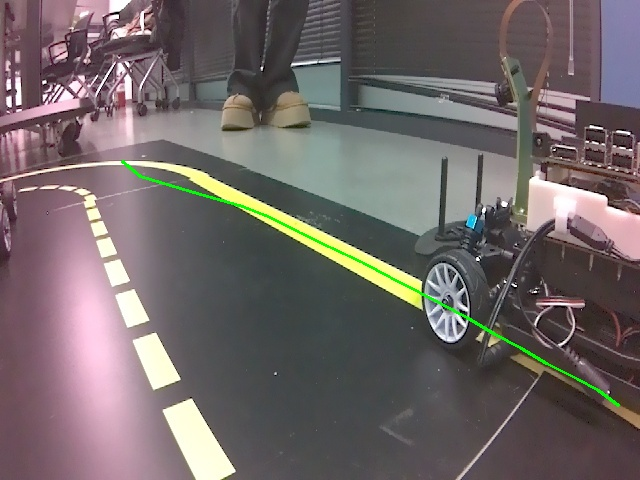

In [12]:
model.eval()

for phase in ['train', 'test']:
    test_dataset = UFLDDataset(**dataset_config, phase=phase)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    tbar = tqdm(test_loader)
    for i, data in enumerate(tbar):
        with torch.no_grad():
            image, cls_label, image_path = data
            results = predict(model, data[:2], device, use_aux)
            # print(results['cls_out'].shape)
            lanes = generate_lanes(results['cls_out'][0], image_size, num_grid)
            coords = grid2coords(lanes, rescaled_row_anchor)

            # Save visualized image
            image_path = Path(image_path[0])
            image = cv2.imread(str(image_path))
            scene_dir = save_dir / image_path.parent.name
            scene_dir.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(scene_dir / image_path.name), visualize_lanes(image, coords))

        # break
Image.open(scene_dir / image_path.name)

In [ ]:
# Generate videos
import cv2
import numpy as np

fps = 5
codec = "XVID" # H264 | VP90 | XVID
output_dir = Path("outputs")
video_dir = Path("videos/preds") / weights_path.parent.name / weights_path.stem
video_dir.mkdir(parents=True, exist_ok=True)
scenes = sorted(output_dir.glob("*"))

for scene_dir in scenes:
    scene_name = scene_dir.name
    images = sorted(scene_dir.glob("*"))
    frame = cv2.imread(str(images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(str(video_dir / f"{scene_name}.mp4"), cv2.VideoWriter_fourcc(*codec), fps, (width, height))

    for image in images:
        video.write(cv2.imread(str(image)))

    video.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
Open